In [1]:
# Install necessary packages
!pip install torch torchvision

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create project directory in Google Drive
import os
project_dir = '/content/drive/My Drive/MobileNetV2_CIFAR10'
os.makedirs(project_dir, exist_ok=True)

print("Project directory and necessary subdirectories created successfully.")

Mounted at /content/drive
Project directory and necessary subdirectories created successfully.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Data transformations for training and testing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
print('==> Preparing data..')
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('Data preparation complete.')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:03<00:00, 43623489.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data preparation complete.


In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride == 1 else out
        return out

class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Initialize the model
print('==> Building model..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MobileNetV2().to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
print('Model built and moved to device.')

==> Building model..
Model built and moved to device.


In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Lists to store metrics
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
f1_history = []
precision_history = []
recall_history = []

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

def train(epoch):
    print(f'\nEpoch: {epoch}')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    train_loss_history.append(train_loss / len(trainloader))
    train_acc_history.append(100. * correct / total)
    f1_history.append(f1_score(all_targets, all_predictions, average='macro'))
    precision_history.append(precision_score(all_targets, all_predictions, average='macro'))
    recall_history.append(recall_score(all_targets, all_predictions, average='macro'))

    print(f'Train Loss: {train_loss / len(trainloader):.3f} | Train Acc: {100. * correct / total:.3f}%')

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss_history.append(test_loss / len(testloader))
    test_acc_history.append(100. * correct / total)
    f1_history.append(f1_score(all_targets, all_predictions, average='macro'))
    precision_history.append(precision_score(all_targets, all_predictions, average='macro'))
    recall_history.append(recall_score(all_targets, all_predictions, average='macro'))

    acc = 100. * correct / total
    if acc > best_acc:
        print('Saving checkpoint..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        torch.save(state, f'{project_dir}/ckpt.pth')
        best_acc = acc

    print(f'Test Loss: {test_loss / len(testloader):.3f} | Test Acc: {acc:.3f}%')

In [ ]:
print('==> Starting training..')
for epoch in range(start_epoch, start_epoch + 2):
    train(epoch)
    test(epoch)
    scheduler.step()

    # Save training history
    torch.save({
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'test_loss': test_loss_history,
        'test_acc': test_acc_history,
        'f1': f1_history,
        'precision': precision_history,
        'recall': recall_history,
    }, f'{project_dir}/history.pth')
print('Training complete.')

==> Starting training..

Epoch: 0
Train Loss: 1.586 | Train Acc: 42.520%
Saving checkpoint..
Test Loss: 1.319 | Test Acc: 52.310%

Epoch: 1
Train Loss: 1.074 | Train Acc: 61.558%
Saving checkpoint..
Test Loss: 1.122 | Test Acc: 61.690%

Epoch: 2
Train Loss: 0.852 | Train Acc: 69.898%
Saving checkpoint..
Test Loss: 0.963 | Test Acc: 68.370%

Epoch: 3
Train Loss: 0.751 | Train Acc: 73.680%
Saving checkpoint..
Test Loss: 0.723 | Test Acc: 74.850%

Epoch: 4
Train Loss: 0.688 | Train Acc: 76.094%
Test Loss: 0.732 | Test Acc: 74.710%

Epoch: 5
Train Loss: 0.648 | Train Acc: 77.496%
Test Loss: 0.732 | Test Acc: 74.100%

Epoch: 6
Train Loss: 0.628 | Train Acc: 78.250%
Test Loss: 0.868 | Test Acc: 71.220%

Epoch: 7
Train Loss: 0.614 | Train Acc: 78.828%
Test Loss: 0.808 | Test Acc: 72.840%

Epoch: 8
Train Loss: 0.601 | Train Acc: 79.300%
Saving checkpoint..
Test Loss: 0.714 | Test Acc: 75.290%

Epoch: 9
Train Loss: 0.603 | Train Acc: 79.280%
Saving checkpoint..
Test Loss: 0.649 | Test Acc: 77.8

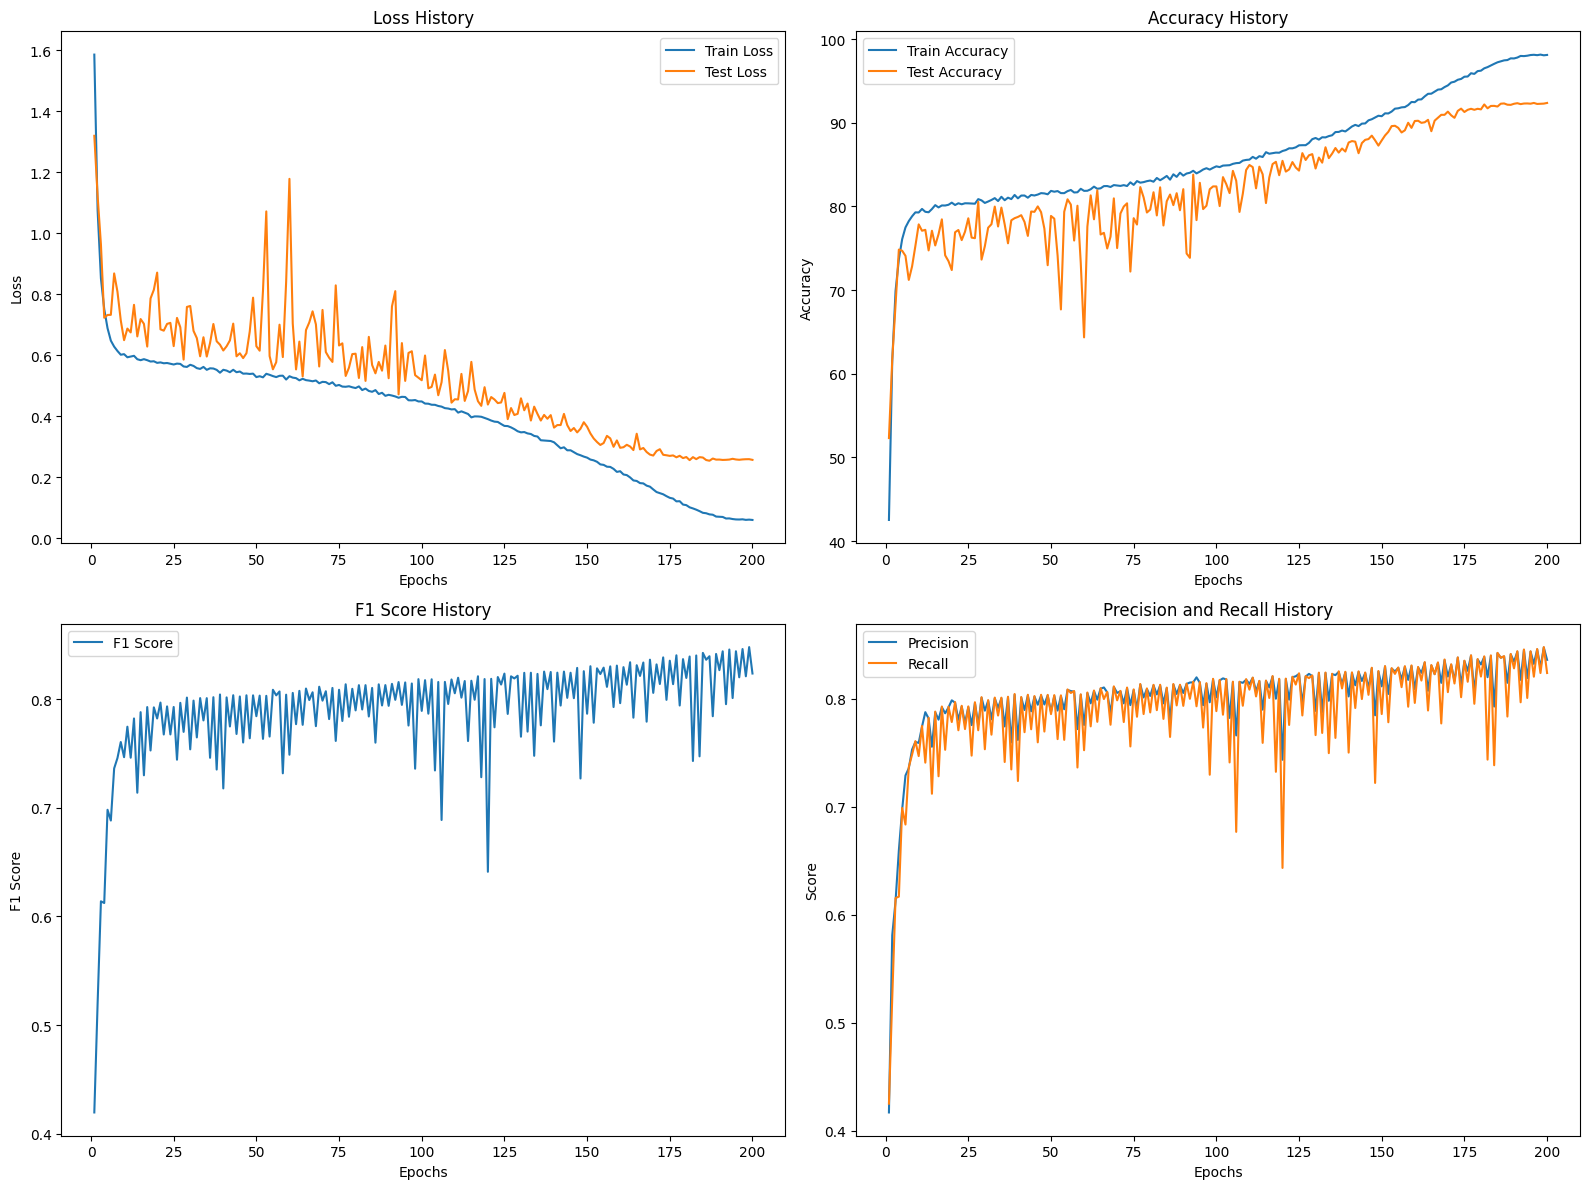

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load history
history = torch.load(f'{project_dir}/history.pth')

def plot_history():
    # Determine the minimum length of the history lists to avoid dimension mismatch
    min_length = min(len(history['train_loss']), len(history['test_loss']),
                     len(history['train_acc']), len(history['test_acc']),
                     len(history['f1']), len(history['precision']), len(history['recall']))

    epochs = range(1, min_length + 1)

    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'][:min_length], label='Train Loss')
    plt.plot(epochs, history['test_loss'][:min_length], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'][:min_length], label='Train Accuracy')
    plt.plot(epochs, history['test_acc'][:min_length], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['f1'][:min_length], label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score History')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['precision'][:min_length], label='Precision')
    plt.plot(epochs, history['recall'][:min_length], label='Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Precision and Recall History')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{project_dir}/training_plots.png')
    plt.show()

plot_history()

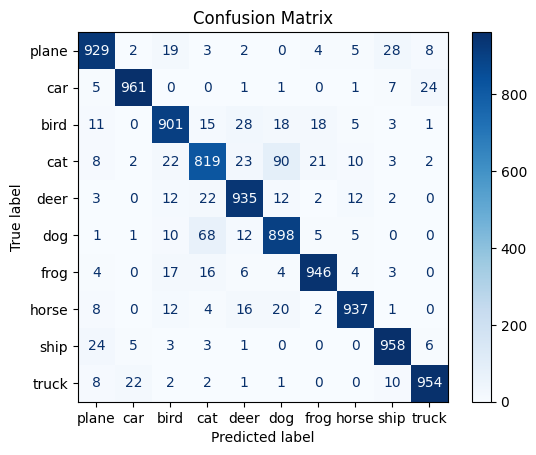

In [ ]:
def plot_confusion_matrix():
    # Confusion matrix on the test set
    net.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_targets, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(f'{project_dir}/confusion_matrix.png')
    plt.show()

plot_confusion_matrix()


<ipython-input-8-af9b4c5c0f2e>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=torch.device('cpu'))
<ipython-input-8-af9b4c5c0f2

Checkpoint Contents:
Epoch: 195
Accuracy: 92.38
Model State Dict Keys:
odict_keys(['module.conv1.weight', 'module.bn1.weight', 'module.bn1.bias', 'module.bn1.running_mean', 'module.bn1.running_var', 'module.bn1.num_batches_tracked', 'module.layers.0.conv1.weight', 'module.layers.0.bn1.weight', 'module.layers.0.bn1.bias', 'module.layers.0.bn1.running_mean', 'module.layers.0.bn1.running_var', 'module.layers.0.bn1.num_batches_tracked', 'module.layers.0.conv2.weight', 'module.layers.0.bn2.weight', 'module.layers.0.bn2.bias', 'module.layers.0.bn2.running_mean', 'module.layers.0.bn2.running_var', 'module.layers.0.bn2.num_batches_tracked', 'module.layers.0.conv3.weight', 'module.layers.0.bn3.weight', 'module.layers.0.bn3.bias', 'module.layers.0.bn3.running_mean', 'module.layers.0.bn3.running_var', 'module.layers.0.bn3.num_batches_tracked', 'module.layers.0.shortcut.0.weight', 'module.layers.0.shortcut.1.weight', 'module.layers.0.shortcut.1.bias', 'module.layers.0.shortcut.1.running_mean', 'mo

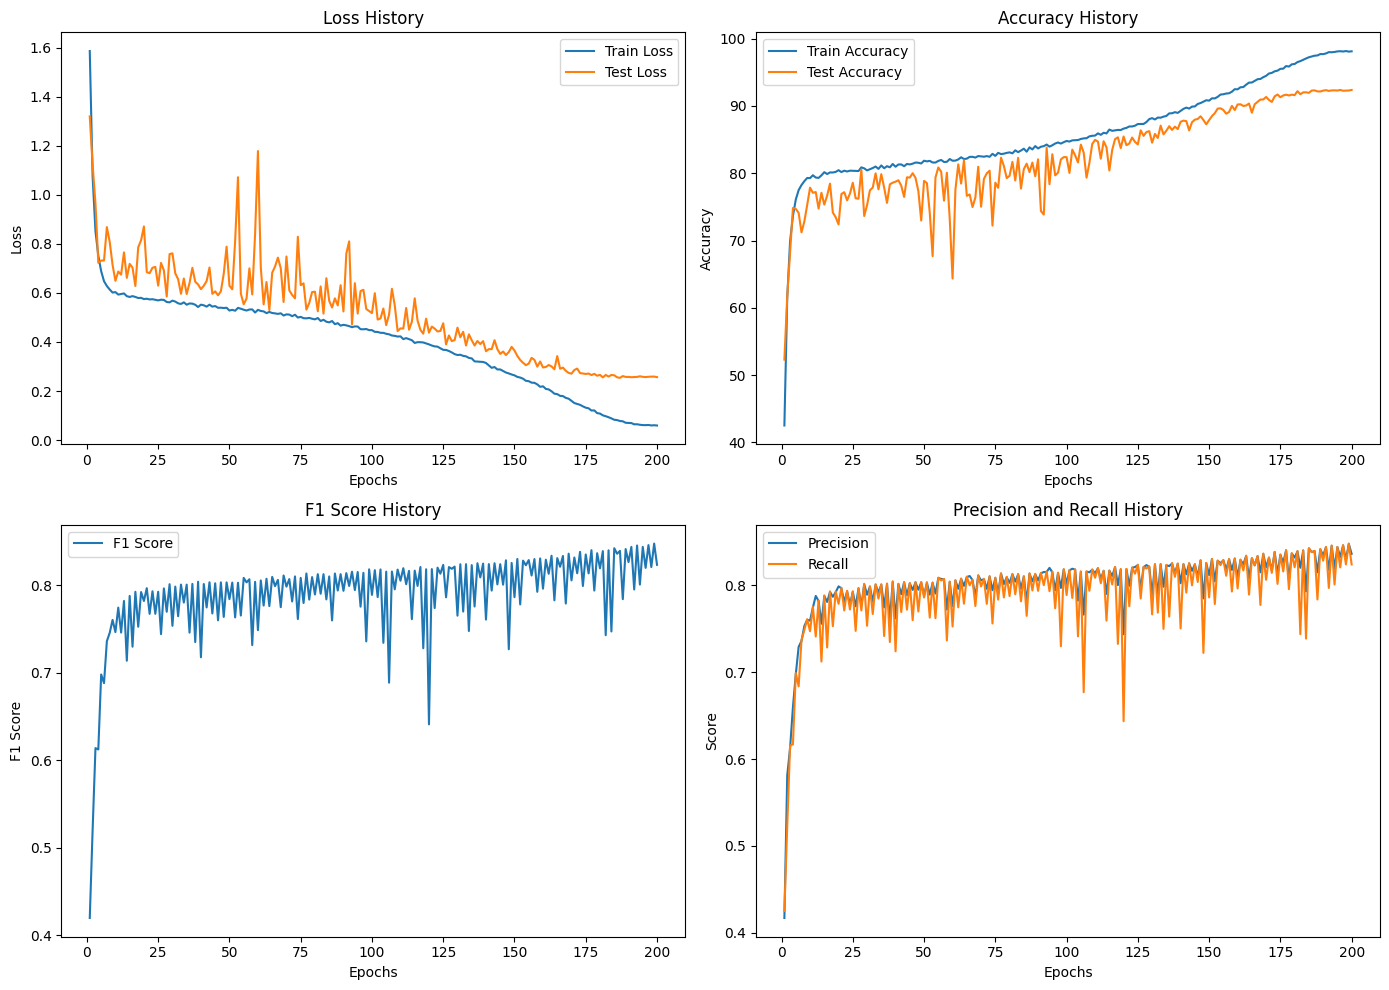

In [8]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the project directory (extracted from the provided file)
project_dir = '/content/drive/My Drive/MobileNetV2_CIFAR10'
ckpt_path = f'{project_dir}/ckpt.pth'
history_path = f'{project_dir}/history.pth'

# Load functions
def load_checkpoint(path):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    return checkpoint

def load_history(path):
    history = torch.load(path, map_location=torch.device('cpu'))
    return history

# Print functions
def print_checkpoint(checkpoint):
    print("Checkpoint Contents:")
    print(f"Epoch: {checkpoint['epoch']}")
    print(f"Accuracy: {checkpoint['acc']}")
    print("Model State Dict Keys:")
    print(checkpoint['net'].keys())

def print_history(history):
    print("History Contents:")
    print(history.keys())
    for key, value in history.items():
        print(f"{key}: {value[:5]}...")  # Print first 5 entries for brevity

# Plotting functions
def plot_history(history):
    min_length = min(len(history['train_loss']), len(history['test_loss']),
                     len(history['train_acc']), len(history['test_acc']),
                     len(history['f1']), len(history['precision']), len(history['recall']))

    epochs = range(1, min_length + 1)

    # Plot Loss
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'][:min_length], label='Train Loss')
    plt.plot(epochs, history['test_loss'][:min_length], label='Test Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'][:min_length], label='Train Accuracy')
    plt.plot(epochs, history['test_acc'][:min_length], label='Test Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['f1'][:min_length], label='F1 Score')
    plt.title('F1 Score History')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot Precision and Recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['precision'][:min_length], label='Precision')
    plt.plot(epochs, history['recall'][:min_length], label='Recall')
    plt.title('Precision and Recall History')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{project_dir}/training_plots.png')
    plt.show()

def main():
    # Load and print checkpoint
    checkpoint = load_checkpoint(ckpt_path)
    print_checkpoint(checkpoint)

    # Load and print history
    history = load_history(history_path)
    print_history(history)

    # Plot metrics
    plot_history(history)

    # Compute and print confusion matrix for the best/latest epoch
    # Assuming the last entry contains the targets and predictions
    y_true = history.get('targets', [None])[-1]
    y_pred = history.get('predictions', [None])[-1]
    if y_true is not None and y_pred is not None:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

if __name__ == "__main__":
    main()


<ipython-input-9-163aaca3c1bd>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{project_dir}/ckpt.pth')


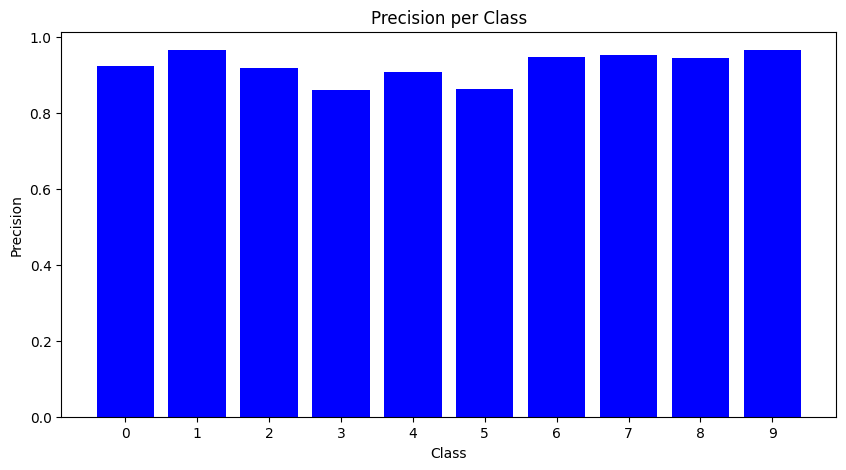

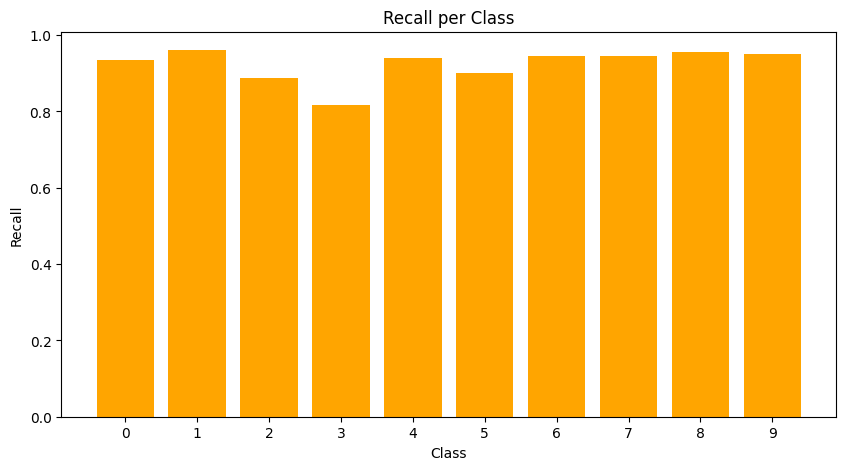

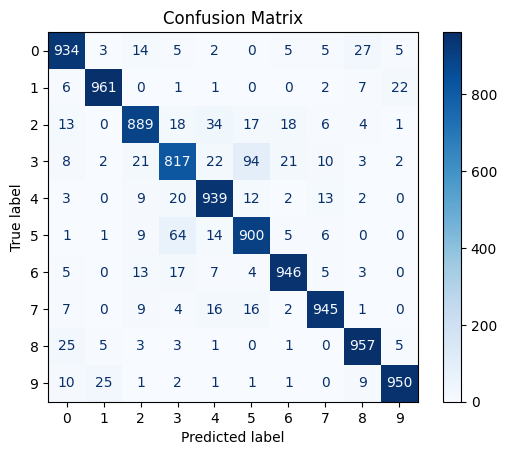

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# Load best model
checkpoint = torch.load(f'{project_dir}/ckpt.pth')
net.load_state_dict(checkpoint['net'])

# Function to compute precision, recall, and confusion matrix
def compute_metrics(loader):
    net.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision, recall, _, _ = precision_recall_fscore_support(all_targets, all_predictions, average=None)
    cm = confusion_matrix(all_targets, all_predictions)
    return precision, recall, cm

# Compute precision, recall, and confusion matrix for test data
precision, recall, cm = compute_metrics(testloader)

# Generate a timestamp to uniquely name the plots
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Plot precision matrix
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(precision)), precision, color='blue')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(np.arange(len(precision)), np.arange(len(precision)))
plt.savefig(f'{project_dir}/precision_matrix_{timestamp}.png')
plt.show()

# Plot recall matrix
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(recall)), recall, color='orange')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall per Class')
plt.xticks(np.arange(len(recall)), np.arange(len(recall)))
plt.savefig(f'{project_dir}/recall_matrix_{timestamp}.png')
plt.show()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(f'{project_dir}/confusion_matrix_{timestamp}.png')
plt.show()
